# Reading PHYSLITE files using the `PHYSLITESchema`

`NanoEvents` is a `coffea` utility to wrap NTuple structures (such as the ATLAS PHYSLITE format) into a single awkward array with appropriate object methods (such as Lorentz vector methods), cross references, and nested objects. All are by default accessed in delayed* mode from the input ROOT TTree via `uproot`.  

The interpretation of the TTree data is configurable via schema objects, which are community-supplied for various input file types. Relevant schemas for this training:
1. `BaseSchema`, which provides a simple representation of the input TTree, where each branch is available verbatim as `events.branch_name`. Any branches that `uproot` supports at "full speed" (i.e. that are fully split and either flat or single-jagged) can be read by this schema.
2. `PHYSLITESchema`, for the ATLAS PHYSLITE derivations.

The schema code, along with their specialized methods, can be found here: https://github.com/CoffeaTeam/coffea/tree/master/src/coffea/nanoevents

\* _delayed_ access refers to only fetching the needed data from the file when you're ready to compute the needed quantities. Until then, a minimal amount of metadata is used to trace the operations to eventually be performed (frequently called "lazy" evaluation).

In this demo we will read the content of a PHYSLITE file using the `PHYSLITESchema`. The usage and benefits of the schema will be demonstrated.

In [1]:
import coffea
print("coffea version: ", coffea.__version__)
import awkward as ak
print("awkward version: ", ak.__version__)
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
import numpy as np
import matplotlib.pyplot as plt

coffea version:  2024.6.1
awkward version:  2.6.5


Let's load a PHYSLITE file containing simulated event data describing the production the Higgs boson and its decay via a pair of Z bosons to a four lepton final state. Those data are part of the recent ATLAS open data release and can be found at DOI:[10.7483/OPENDATA.ATLAS.Z2J9.709J](http://doi.org/10.7483/OPENDATA.ATLAS.Z2J9.709J).

More information about our data release at [this article](https://atlas.cern/Updates/News/Open-Data-Research) and the ATLAS open data portal: https://opendata.atlas.cern/

You can download those files at your local machine or you can stream them directly.

In [2]:
# Hgg -> 4l sample

# local
# file_path = '/MyMachine/Downloads/DAOD_PHYSLITE.38191712._000001.pool.root.1'

# stream
file_path = "root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1"

To make the loading lighter, we will use the `filter_name` function, in order to load only the properties needed. Then we will use `coffea`'s `NanoEventsFactory.from_root` to load the file. Consider looking at the [`from_root`](https://coffeateam.github.io/coffea/api/coffea.nanoevents.NanoEventsFactory.html#coffea.nanoevents.NanoEventsFactory.from_root) class method to see all optional arguments.

All the properties stored in the open data PHYSLITE files are listed in: https://atlas-physlite-content-opendata.web.cern.ch/. For your reference, the equivalent internal webpage for general PHYSLITE files is: https://atlas-physlite-content.web.cern.ch/.

_Some warnings will appear as we're still working with `uproot` and the `PHYSLITESchema` to correctly interpret all the properties stored in PHYSLITE._

In [3]:
# load in memory

def filter_name(name):
    '''
    Load only the properties/variables needed.
    '''
    return name in [
        "EventInfoAuxDyn.mcEventWeights",
        
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        "AnalysisElectronsAuxDyn.DFCommonElectronsLHLoose",
        "AnalysisElectronsAuxDyn.charge",
        
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        "AnalysisMuonsAuxDyn.quality",
        
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.m",
        
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu",
    ]

events = NanoEventsFactory.from_root(
    {file_path: "CollectionTree"}, # all the event properties are stored in the TTree called CollectionTree
    schemaclass=PHYSLITESchema, # tell NanoEventsFactory.from_root that you read a PHYSLITE file
    uproot_options=dict(filter_name=filter_name)
).events()

/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/nanoevents/methods/physlite.py:10: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import base, vector
/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/util.py:234: UserWarning: Skipping xTrigDecisionAux.xAOD::AuxInfoBase as it is not interpretable by Uproot
  warnings.warn(
/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/util.py:

The `events` object is an awkward array, which at its top level is a record array with one record for each "collection", where a collection is a grouping of properties (TBranches) based on the naming conventions of `PHYSLITESchema`. For example, in the file we opened there are the collections:

In [4]:
events.fields

['Electrons', 'Jets', 'BTagging_AntiKt4EMPFlow', 'EventInfo', 'Muons']

For each collection, we can list the properties that have been loaded. For example, let's look at the properties of the `Electrons`:

In [5]:
events.Electrons.fields

['pt', '_eventindex', 'eta', 'phi', 'm', 'charge', 'DFCommonElectronsLHLoose']

The data in a PHYSLITE file are highly structured but jagged. In other words, in each event there are different number of objects, thus the awkward arrays are not rectilinear but _awkward_. We can see that if we actually compute an awkward array containing electron objects.

_This is the first time we will call the `compute()` method. Actual number crunching is happening here!_

In [6]:
events.Electrons.compute()

<ElectronArray [[Electron, ..., Electron], ...] type='50000 * var * electron'>

## Slicing

One of the most common operations you will found yourself doing is event selection or array _slicing_. We can practice this by first defining an awkward (boolean) array by a logical operation. Then we can use this array as an argument to slice our events.

For example, let's request events with at least two electrons:

In [7]:
# define boolean array
selection_2e = ak.num(events.Electrons, axis=-1) > 1

# print the selected events
events[selection_2e].compute()

<NanoEventsArray [{Electrons: [...], Jets: ..., ...}, ...] type='25452 * event'>

Notice how the number of events in the awkward array has been reduced.

In [8]:
# print the second of the selected events
events[selection_2e][1].compute()

<NanoEventsRecord {Electrons: [Electron, ...], Jets: [...], ...} type='event'>

In [9]:
# print the leading electron pt of the selected events
events.Electrons[selection_2e][:, 0].pt.compute() # in MeV
# events[selection_2e][:, "Electrons"][:, "pt"][:, 0].compute() # another uglier way to write this

<Array [4.36e+04, 3.45e+04, ..., 4.27e+04] type='25452 * float32[parameters...'>

Next, we can demonstrate something more complicated. This is an example of the power of the schemas. We will use a utility method `delta_r` to calculate the distance $\Delta R = \sqrt{\Delta\eta^2+\Delta\phi^2}$ between two LorentzVector objects. In particular, we will calculate the distance between the leading and sub-leading electrons in each event. Of course, we need to make use we use events that have at least two electrons, thus we will utilize the `selection_2e` from above.

To plot a histogram we will just use `matplotlib` for the moment. You might want to use the `hist` library which you will learn about this afternoon:

https://indico.cern.ch/event/1376945/timetable/?view=standard#33-introduction-to-hist

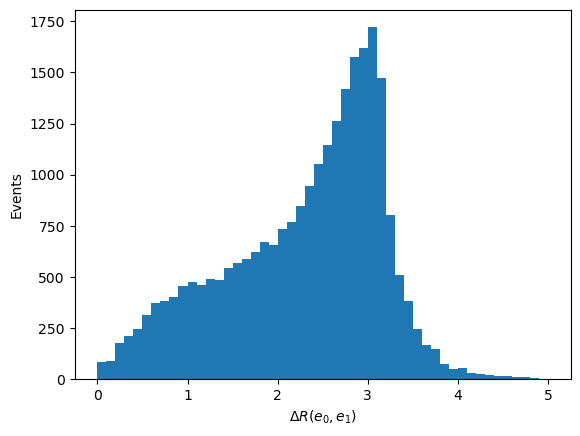

In [10]:
# distance between leading and sub-leading electron in every event
dr = events.Electrons[selection_2e][:, 0].delta_r(events.Electrons[selection_2e][:, 1])

# compute and plot
plt.hist(dr.compute(), bins=50, range=(0, 5))
plt.xlabel(r"$\Delta R(e_0, e_1)$")
plt.ylabel("Events")
plt.show()

Let's now use the schema to calculate the invariant mass of a group of particles. In particular, calculate and plot the invariant mass of the four leading electrons of each event.

In [11]:
# your code here

<details>
<summary><b>Answer</b></summary>

```python
# define logical array to select events with 4 electrons
selection_4e = ak.num(events.Electrons, axis=-1) == 4

# calculate the invariant mass of the 4 electrons
mass = (events.Electrons[selection_4e][:, 0] + 
        events.Electrons[selection_4e][:, 1] + 
        events.Electrons[selection_4e][:, 2] + 
        events.Electrons[selection_4e][:, 3]).mass

# compute and plot
plt.hist(mass.compute()/1000, bins=10, range=(100, 150))
plt.xlabel(r"$m(e_0, e_1)$ [GeV]")
plt.ylabel("Events")
plt.show()
```
</details>

## Element Links

In [12]:
# naive ElementLinking
def calculate_jets_DL1dv01(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DL1dv01 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)
    DL1dv01 = np.log(DL1dv01)

    return DL1dv01

In [13]:
# assign new variables to the arrays
events['Jets', 'DL1dv01'] = calculate_jets_DL1dv01(events)

events.Jets.fields

['pt', '_eventindex', 'eta', 'phi', 'm', 'DL1dv01']

In [14]:
events.Jets.DL1dv01.compute()

<Array [[-1.5, -2.88, -1.99], ..., [-2.56, ...]] type='50000 * var * float32'>